In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from metpy.plots import SkewT

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
DATASETS_DIR = f"{BASE_DIR}/datasets"
fp = f"{DATASETS_DIR}/air.mon.ltm.1981-2010.nc"

if not os.path.exists(fp):
    print("Downloading NCEP air data ...")
    ncep_url = (
        "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/"
    )
    ncep_air = xr.open_dataset(
        ncep_url + "pressure/air.mon.1981-2010.ltm.nc#mode=bytes",
        use_cftime=True,
    )
    ncep_air.to_netcdf(fp)
else:
    print("Loading NCEP air data ...")
    ncep_air = xr.open_dataset(fp, use_cftime=True)

Loading NCEP air data ...


In [3]:
ncep_air

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [4]:
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")
Tobs = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))

In [5]:
plt.rcParams.update({"font.size": 12})

In [6]:
import climlab
import gymnasium as gym
import pandas as pd
import scipy
import tephi
from gymnasium import spaces
from matplotlib.gridspec import GridSpec


class RadiativeConvectiveModelEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode=None, locale="uk"):
        self.min_emissivity = 0  # perfect reflector
        self.max_emissivity = 1  # black body

        self.min_adj_lapse_rate = 5.5
        self.max_adj_lapse_rate = 9.8  # dry adiabatic lapse rate

        self.min_temperature = -90
        self.max_temperature = 90

        self.action_space = spaces.Box(
            low=np.array(
                [self.min_emissivity, self.min_adj_lapse_rate],
                dtype=np.float32,
            ),
            high=np.array(
                [self.max_emissivity, self.max_adj_lapse_rate],
                dtype=np.float32,
            ),
            shape=(2,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(
            low=self.min_temperature,
            high=self.max_temperature,
            shape=(len(Tobs.level),),
            dtype=np.float32,
        )

        assert (
            render_mode is None or render_mode in self.metadata["render_modes"]
        )

        # with open(f"{DATASETS_DIR}/climlab_rcm_200.pkl", "rb") as file:
        #     self.climlab_rcm = pickle.load(file)

        self.locale = locale
        self.render_mode = render_mode
        self.reset()

    def _get_obs(self):
        return self._get_temp().values

    def _get_temp(self, model="RL"):
        if model == "RL":
            rcm = self.rcm
        elif model == "climlab":
            rcm = self.climlab_rcm
        temp = np.concatenate([rcm.Tatm, rcm.Ts], dtype=np.float32)
        temp -= climlab.constants.tempCtoK
        temp = xr.DataArray(temp, coords={"level": Tobs.level.values[::-1]})
        return temp

    def _get_info(self):
        return {"_": None}

    def _get_params(self):
        emissivity = self.rcm.subprocess["Radiation (net)"].emissivity
        adj_lapse_rate = self.rcm.subprocess["Convection"].adj_lapse_rate
        params = np.array([emissivity, adj_lapse_rate], dtype=np.float32)
        return params

    def _get_state(self):
        state = self._get_temp().values
        return state

    def step(self, action):
        emissivity, adj_lapse_rate = action[0], action[1]

        emissivity = np.clip(
            emissivity, self.min_emissivity, self.max_emissivity
        )
        adj_lapse_rate = np.clip(
            adj_lapse_rate, self.min_adj_lapse_rate, self.max_adj_lapse_rate
        )
        # adj_lapse_rate = (self.max_adj_lapse_rate - self.min_adj_lapse_rate) * scipy.special.expit(adj_lapse_rate)
        # adj_lapse_rate += self.min_adj_lapse_rate

        self.rcm.subprocess["Radiation (net)"].emissivity = emissivity
        self.rcm.subprocess["Convection"].adj_lapse_rate = adj_lapse_rate
        self.rcm.step_forward()
        self.climlab_rcm.step_forward()

        Tprofile = self._get_temp().values
        costs = np.mean((Tprofile - Tobs.values[::-1]) ** 2)

        self.state = self._get_state()

        return self._get_obs(), -costs, False, False, self._get_info()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        rce_state = climlab.column_state(lev=Tobs.level[1:], water_depth=2.5)
        h2o = climlab.radiation.ManabeWaterVapor(
            state=rce_state, lev=Tobs.level[1:]
        )
        rad = climlab.radiation.RRTMG(
            name="Radiation (net)",
            state=rce_state,
            specific_humidity=h2o.q,
            S0=1365.0,
            timestep=climlab.constants.seconds_per_day,
            albedo=0.25,
        )

        conv = climlab.convection.ConvectiveAdjustment(
            name="Convection",
            state=rce_state,
            adj_lapse_rate=6.5,
            timestep=rad.timestep,
        )

        self.rcm = climlab.couple([rad, conv], name="RCE Model w/ RL")

        # Start from Radiative Equlibrium
        # for n in range(1000):
        #     self.rcm.subprocess["Radiation (net)"].step_forward()

        # Start from Isothermal initial state
        self.rcm.state.Tatm[:] = self.rcm.state.Ts

        # Initialize a climlab RCM model clone
        self.climlab_rcm = climlab.process_like(self.rcm)
        self.climlab_rcm.name = "RCE Model"

        self.state = self._get_state()
        return self._get_obs(), self._get_info()

    def _render_frame(self, save_fig=None, idx=None):
        fig = plt.figure(figsize=(27, 9))
        gs = GridSpec(1, 3, figure=fig)

        params = self._get_params()

        Tprofile_RL = self._get_temp()
        T_diff_RL = Tobs.sel(level=[100, 200]) - Tprofile_RL.sel(
            level=[100, 200]
        )
        T_diff_RL = np.abs(T_diff_RL)

        Tprofile_climlab = self._get_temp(model="climlab")
        T_diff_climlab = Tobs.sel(level=[100, 200]) - Tprofile_climlab.sel(
            level=[100, 200]
        )
        T_diff_climlab = np.abs(T_diff_climlab)

        # Left subplot: emissivity and adj_lapse_rate as bar plots
        ax1 = fig.add_subplot(gs[0, 0])

        ax1_labels = ["Emissivity", "Adj Lapse Rate"]
        ax1_colors = ["tab:blue", "tab:blue"]
        ax1_bars = ax1.bar(ax1_labels, params, color=ax1_colors, width=0.75)
        ax1.set_ylim(0, 10)
        ax1.set_ylabel("Value", fontsize=14)
        ax1.set_title("Parameters")

        # Add values on top of the bars
        for bar in ax1_bars:
            height = bar.get_height()
            ax1.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

        if self.locale == "us":

            # Middle subplot: Skew-T plot

            skew = SkewT(fig, subplot=gs[0, 1], rotation=30)
            self._make_skewT(skew, "SkewT-logP")
            self._add_profile(skew, self.rcm)
            self._add_profile(skew, self.climlab_rcm)

        elif self.locale == "uk":

            # Middle subplot: Tephigram

            ax2 = fig.add_subplot(gs[0, 1])
            tpg = tephi.Tephigram(
                figure=ax2.get_figure(), anchor=[(1000, -10), (70, -25)]
            )
            tpg.plot(
                self._get_tephigram_data(self.rcm),
                label=self.rcm.name,
                color="tab:blue",
            )
            tpg.plot(
                self._get_tephigram_data(self.climlab_rcm),
                label=self.climlab_rcm.name,
                color="tab:orange",
            )
            tpg.plot(
                zip(Tobs.level, Tobs),
                color="black",
                linestyle="-",
                linewidth=2,
                label="Observations",
            )
            tpg.axes.legend()
            # ax2.set_title("Tephigram")
            ax2.set_axis_off()

        # Right subplot: emissivity and adj_lapse_rate as bar plots
        ax3 = fig.add_subplot(gs[0, 2])
        ax3_bar_width = 0.4
        ax3_labels = ["T_diff @ 100hPa", "T_diff @ 200 hPa"]
        ax3_ind = np.arange(1, 1 + len(ax3_labels))
        ax3_colors_RL = ["tab:blue", "tab:blue"]
        ax3_bars_RL = ax3.bar(
            ax3_ind - (ax3_bar_width / 2),
            T_diff_RL,
            color=ax3_colors_RL,
            width=ax3_bar_width,
        )
        ax3_colors_climlab = ["tab:orange", "tab:orange"]
        ax3_bars_climlab = ax3.bar(
            ax3_ind + (ax3_bar_width / 2),
            T_diff_climlab,
            color=ax3_colors_climlab,
            width=ax3_bar_width,
        )
        ax3.set_ylim(0, 10)
        ax3.set_ylabel("Difference [$\degree$C]", fontsize=14)
        ax3.set_title("Temperature Differences")
        ax3.set_xticks(ax3_ind)
        ax3.set_xticklabels(ax3_labels)
        ax3.legend(
            (ax3_bars_RL[0], ax3_bars_climlab[0]),
            ("RCE Model w/ RL", "RCE Model"),
        )

        # Add values on top of the bars
        ax3_bars = ax3_bars_RL + ax3_bars_climlab
        for bar in ax3_bars:
            height = bar.get_height()
            ax3.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

        extent = ax2.get_window_extent().transformed(
            fig.dpi_scale_trans.inverted()
        )
        if save_fig:
            plt.savefig(
                f"{BASE_DIR}/tmp/rce-v0-tephigram_{idx}.pdf",
                format="pdf",
                bbox_inches=extent.expanded(1.22, 1.15),
            )

        return fig

    def _get_tephigram_data(self, rcm):

        temp = np.concatenate([rcm.Tatm, rcm.Ts], dtype=np.float32)
        temp -= climlab.constants.tempCtoK
        levels = np.concatenate([rcm.lev, [1000]], dtype=np.float32)

        df = pd.DataFrame(zip(levels, temp))
        df.columns = ["pressure", "temperature"]

        return df.values

    def _make_skewT(self, skew, title=None):
        skew.plot(
            Tobs.level,
            Tobs,
            color="black",
            linestyle="-",
            linewidth=2,
            label="Observations",
        )
        skew.ax.set_ylim(1050, 10)
        skew.ax.set_xlim(-90, 45)

        skew.plot_dry_adiabats(linewidth=0.5)
        skew.plot_moist_adiabats(linewidth=0.5)

        skew.ax.legend()
        skew.ax.set_xlabel("Temperature [$\degree$C]", fontsize=14)
        skew.ax.set_ylabel("Pressure [hPa]", fontsize=14)
        if title:
            skew.ax.set_title(title)

    def _add_profile(self, skew, model, linestyle="-", color=None):
        line = skew.plot(
            model.lev,
            model.Tatm - climlab.constants.tempCtoK,
            label=model.name,
            linewidth=2,
        )[0]
        skew.plot(
            1000,
            model.Ts - climlab.constants.tempCtoK,
            "o",
            markersize=8,
            color=line.get_color(),
        )
        skew.ax.legend()

    def render(self, **kwargs):
        if self.render_mode == "human":
            self._render_frame(**kwargs)
            plt.show()
        elif self.render_mode == "rgb_array":
            fig = self._render_frame(**kwargs)
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
            image = image.reshape((height, width, 3))
            plt.close(fig)
            return image

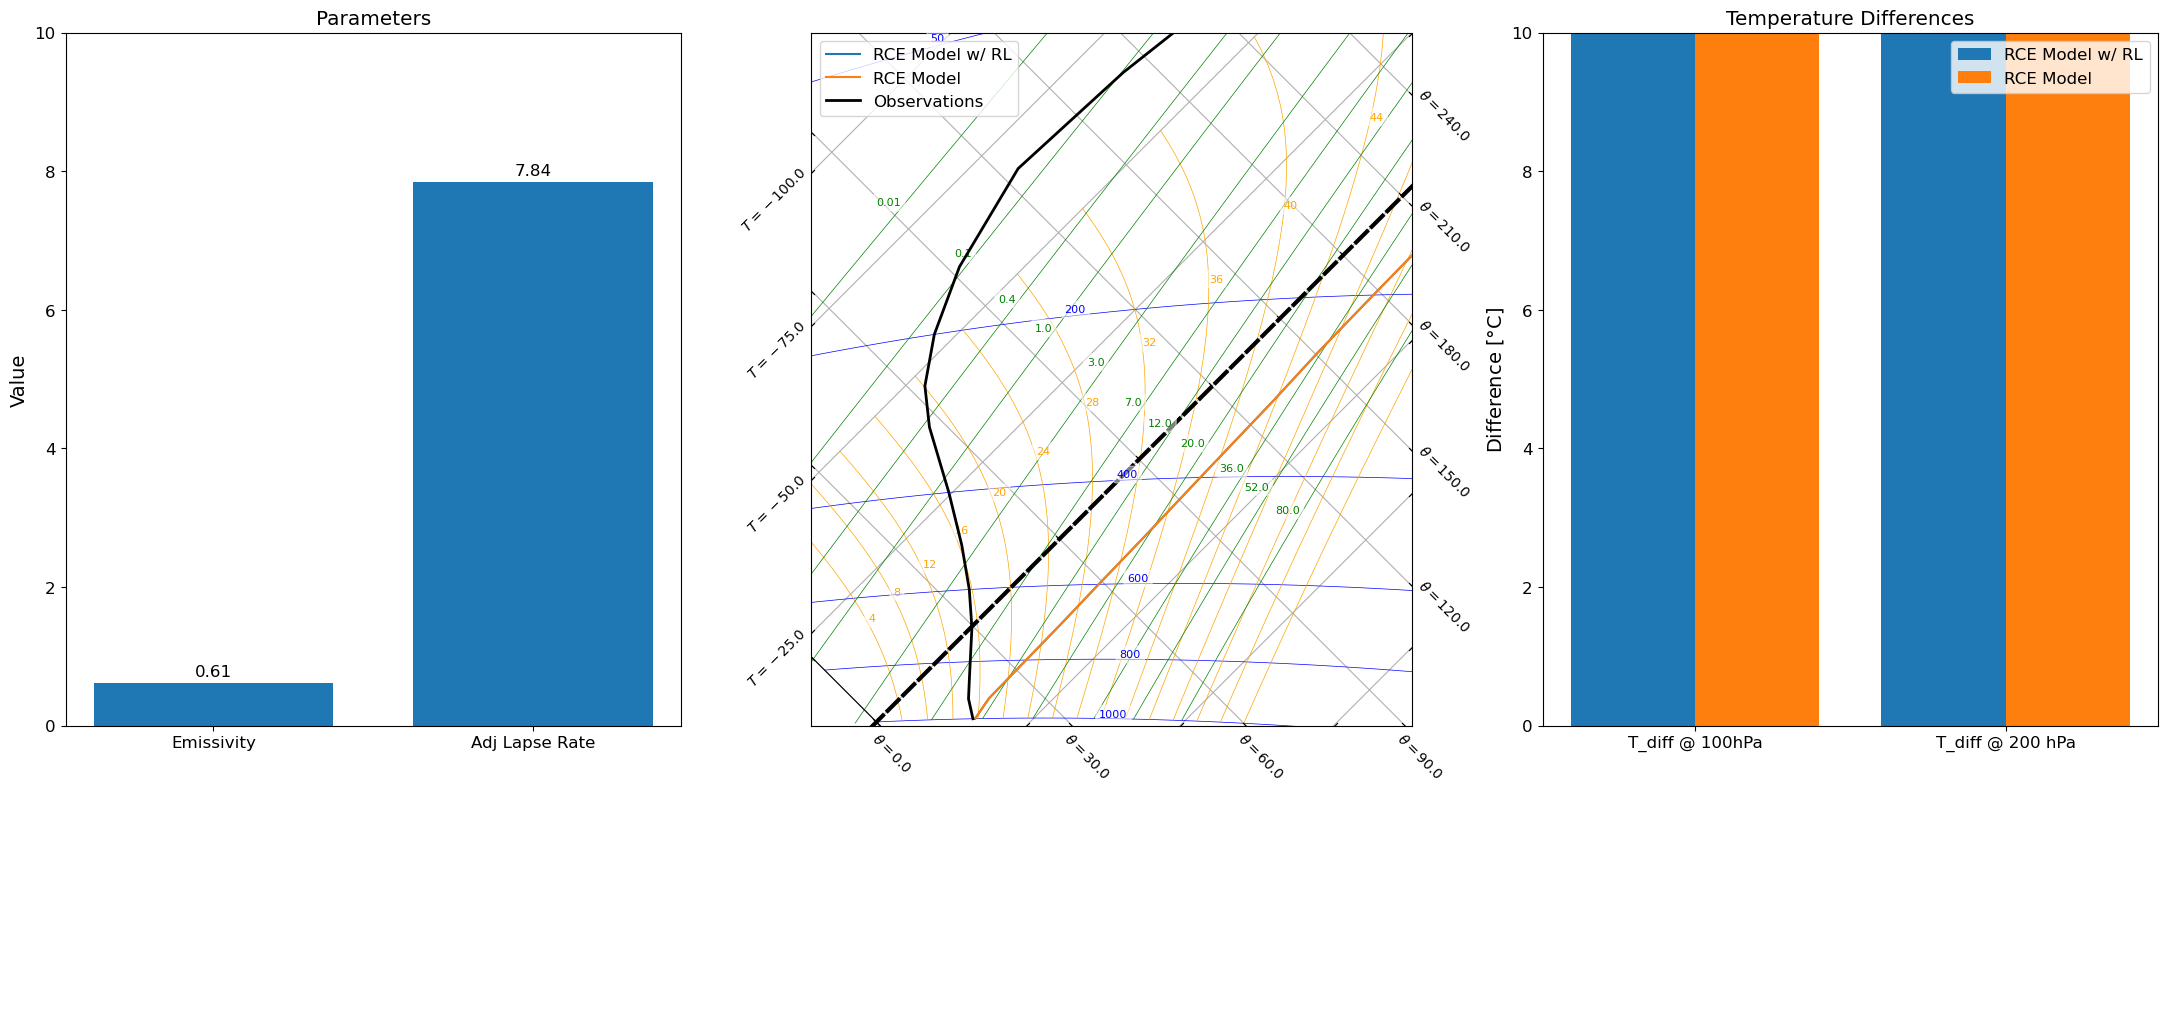

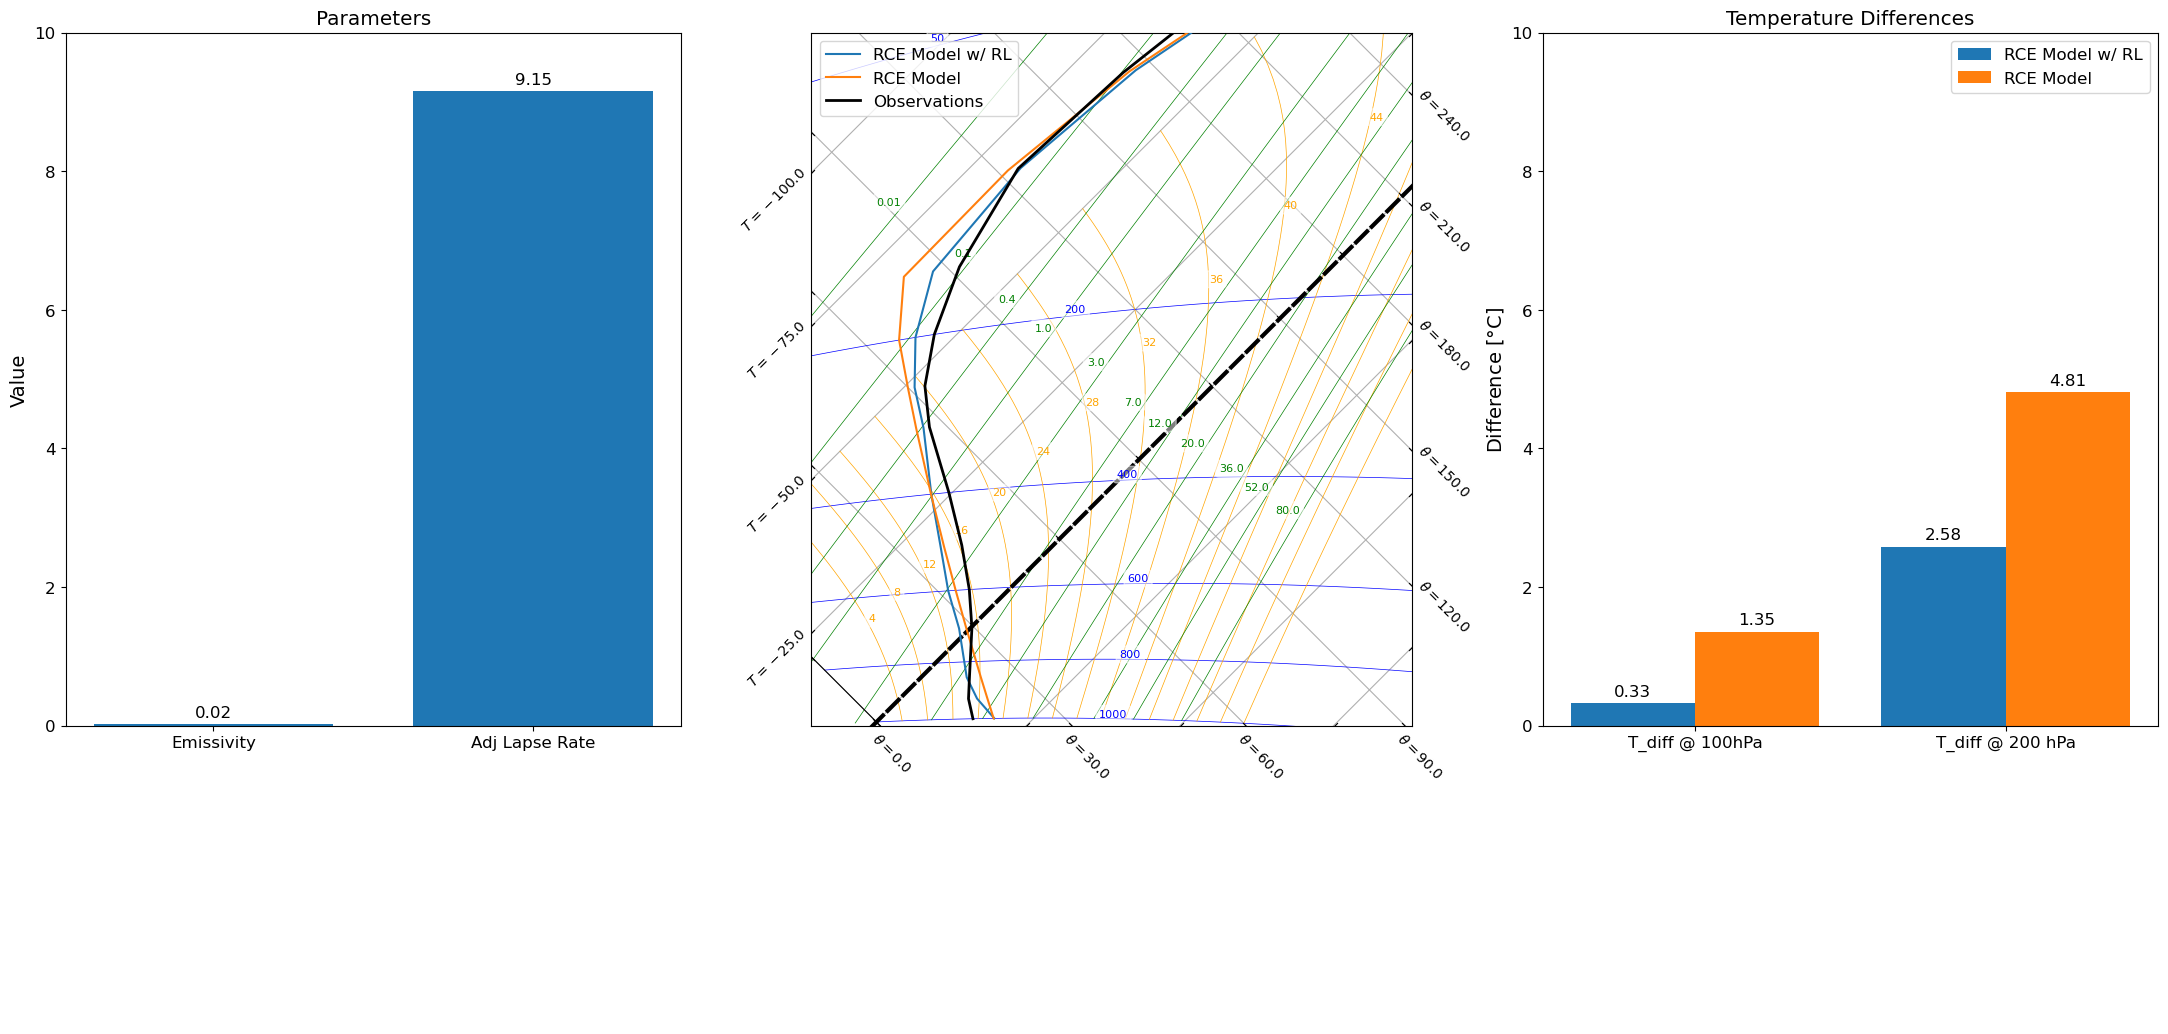

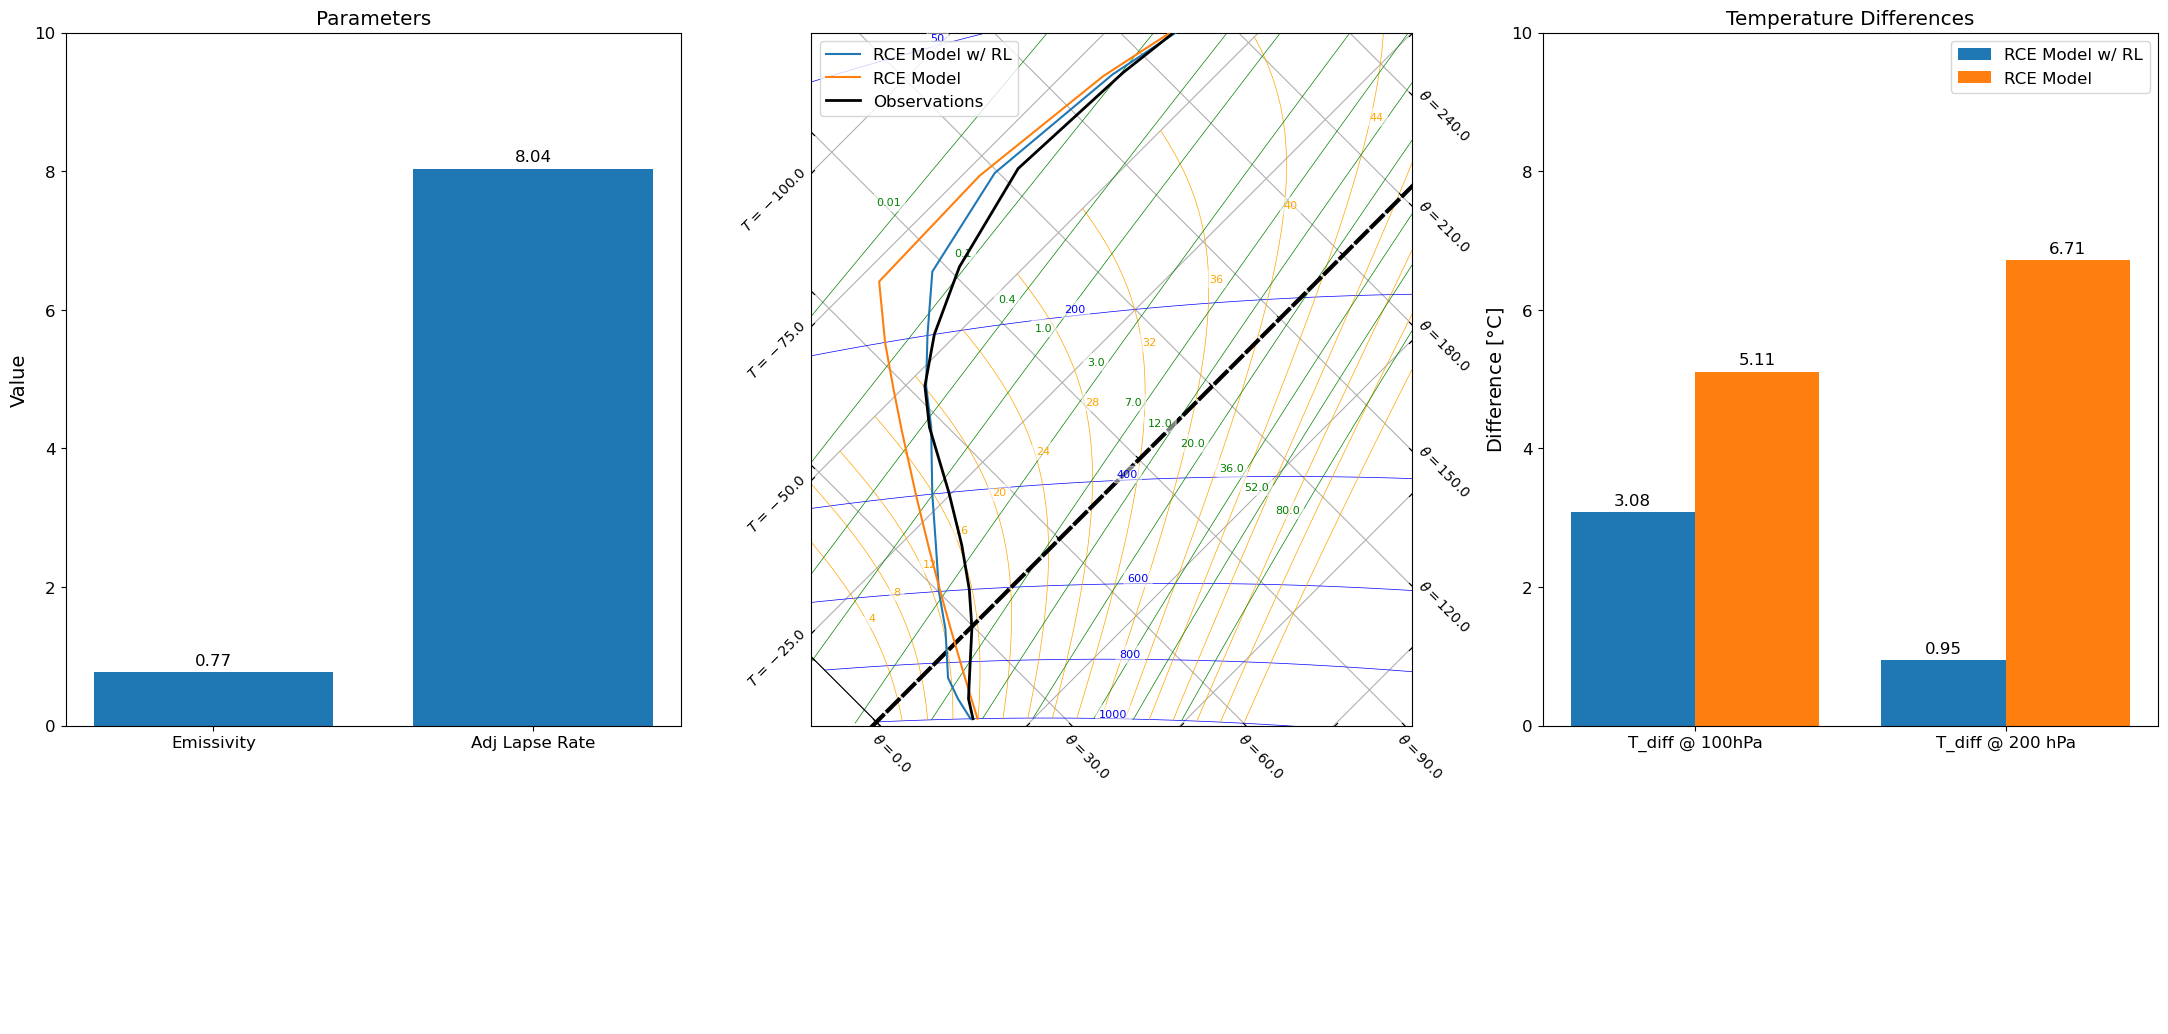

-----
episodic_return=[-46744.93116760254]
-----



In [7]:
# RL Environment [Random Actions]
env = RadiativeConvectiveModelEnv(render_mode="human")
obs, _ = env.reset(seed=1)
episodic_return = 0

for idx in range(500):
    action = env.action_space.sample()
    next_obs, rewards, terminations, truncations, infos = env.step(action)
    episodic_return += rewards

    if (idx == 0) or (idx == 100) or (idx == 200):
        env.render(save_fig=True, idx=idx)

print(f"-----\nepisodic_return=[{episodic_return}]\n-----\n")
env.close()